This script compares word importance distributions between two tokenization scenarios:
(1) word-level tokenization and (2) q-gram-based tokenization with traceability.
It processes three datasets (CheckWorthiness, MeOffendEs, and PoliticEs), extracts TF-IDF
features, trains linear classifiers, and computes word-level importance scores.

For the q-gram scenario, the script includes a post-processing step that aggregates
the model's q-gram coefficients back to original word boundaries. This mirrors the
GWTI tracing mechanism and enables human-interpretable explanations.

The resulting word importance distributions are visualized as boxplots, and a statistical
comparison (paired t-test) is performed to evaluate the gain in interpretability.

In [ ]:
try:
    import microtc
except ImportError:
    !pip install microtc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 2.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from microtc import TextModel
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [ ]:
#fn, umbral = f"/content/drive/MyDrive/datasets/ordenados/CT24_checkworthy_24_sp_2.json", 0.1
# fn, umbral = f"/content/drive/MyDrive/datasets/ds_related/meoffendes2021_task3_Es_test.json", 0.05
#fn, umbral = f"/content/drive/MyDrive/datasets/ds_related/meoffendes2021_task3_Es_train.json", 0.05


#fn, umbral = f"/content/drive/MyDrive/datasets/ds_related/delitos_ingeotec_Es_train.json", 0.5
#fn, umbral = f"/content/drive/MyDrive/datasets/ds_related/metwo22_Es_train.json", 0.005

#fn, umbral = f"/content/drive/MyDrive/datasets/ordenados/checkworthy_Es_train.json", 1.1
#fn, umbral = f"/content/drive/MyDrive/datasets/grams/checkworthy_Es_test.json", 1.1

#fn, umbral = f"/content/drive/MyDrive/datasets/perfilados/IberLEF2023_PoliticEs_gender_Es_test.json", 0.01
#fn, umbral = f"/content/drive/MyDrive/datasets/perfilados/IberLEF2023_PoliticEs_gender_Es_train.json", 0.01

#fn, umbral = f"/content/drive/MyDrive/datasets/perfilados/IberLEF2023_PoliticEs_profession_Es_test.json", 1.5

#fn, umbral = f"/content/drive/MyDrive/datasets/grams/Meoffendes21_Es_test.json", 0.05

#fn, umbral = f"/content/drive/MyDrive/datasets/grams/checkworthy_Es_test.json", 1.1
#fn, umbral = f"/content/drive/MyDrive/datasets/ds_related/meoffendes2021_task3_Es_test.json", 0.05
fn, umbral = f"/content/drive/MyDrive/datasets/grams/PoliticEs_gender_Es_test.json", 0.01


df = pd.read_json(fn, lines=True)
df = df[['text', 'klass']]


In [ ]:
df

,text,klass
0,Días normales “APOYÉMONOS TODOS” “SIEMPRE JUNT...,1
1,@USUARIO @USUARIO @USUARIO Quien lo dice? Un ...,1
2,Desde cuando las morrillas feas se volvieron m...,1
3,"@USUARIO Por eso juegan así, el que debe exig...",0
4,@USUARIO @USUARIO Alv che vieja las dos son un...,1
...,...,...
1007,¿Te gusto? Dile la verdad al mundo maldito mar...,1
1008,"@USUARIO votaste a favor de la corrupción, se ...",1
1009,Mujeres pierden derechos al tener hijos????,0
1010,Lo mejor es que los putos gringos y el pendejo...,1


In [ ]:
# prompt: el df, hacer el split en train y test. Guardarlos como json en "/content/drive/MyDrive/datasets/ordenados/" como train y test respectivamente

if False:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    train_df = pd.DataFrame({'text': X_train, 'klass': y_train})
    test_df = pd.DataFrame({'text': X_test, 'klass': y_test})

    #train_df.to_json("/content/drive/MyDrive/datasets/ordenados/CT24_checkworthy_24_train.json", orient='records', lines=True)
    #test_df.to_json("/content/drive/MyDrive/datasets/ordenados/CT24_checkworthy_24_test.json", orient='records', lines=True)


In [ ]:
df.klass.value_counts()

,count
klass,
male,381
female,166


In [ ]:
# prompt: la columna klass convertirla a integer donde 'journalist' = 0, 'politician'=1 y 'calebrety' = 2
if False:
    mapping = {'journalist': 0, 'politician': 1, 'celebrity': 2}
    mapping = {'male': 0, 'female': 1}
    df['klass'] = df['klass'].map(mapping)
    df['klass'] = df['klass'].astype(int)

df


,text,klass
0,"[Ayer, en Guadalajara: feministas arrojaban ác...",male
1,"[Pues ya he comido, un besi a [POLITICAL_PARTY...",female
2,[La situación de seguridad en mi barrio (vivo ...,male
3,[@user El sector público es un monopolio: solo...,male
4,[Por si finalmente cierra Twitter os dejo mi d...,male
...,...,...
542,[Hoy hace 28 años que ETA asesinó a Gregorio O...,female
543,['Hacer lo mismo que criticamos a los que dest...,female
544,[En el homenaje a las víctimas de la dictadura...,male
545,[“Las cárceles catalanas tienen tasas más alta...,male


In [ ]:
# LinearSVC

#X_train_, X_test_, y_train_, y_test_ = train_test_split(X_vect_, df['klass'], test_size=0.2, random_state=42)
#X_train, X_test = train_test_split(df, test_size=0.20, shuffle = True, random_state=42)

X_train = df.copy()

# words
tm_words = TextModel(token_list=[-1], del_diac=True,  del_dup=False, lc=True, hashtag_option=None, q_grams_words=True, num_option='delete')
tm_words.fit(X_train.text)
tokenized_X = tm_words.transform(X_train.text)



lsvc_words = LinearSVC(penalty='l2', C=1.0, dual=False, max_iter=10000, random_state=42)
lsvc_words.fit(tokenized_X, X_train.klass)


LinearSVC(dual=False, max_iter=10000, random_state=42)

In [ ]:
lsvc_words.coef_[0]

array([ 0.03475193, -0.04539944, -0.0929154 , ...,  0.01140461,
       -0.04921018, -0.21661911])

In [ ]:
# q-grams
tm_q_grams = TextModel(token_list=[2, 3, 4], del_diac=True,  del_dup=False, lc=True, hashtag_option=None, q_grams_words=True, num_option='delete')
tm_q_grams.fit(X_train.text)
tokenized_X_g = tm_q_grams.transform(X_train.text)

lsvc_q_grams = LinearSVC(penalty='l2', C=1.0, dual=False, max_iter=10000, random_state=42)
lsvc_q_grams.fit(tokenized_X_g, X_train.klass)


LinearSVC(dual=False, max_iter=10000, random_state=42)

In [ ]:
lsvc_words.n_features_in_, lsvc_q_grams.n_features_in_

(58360, 54979)

In [ ]:

# obtener solo las Words que superan el Umbral
print(umbral)

all_coefs = lsvc_words.coef_[0]
print(len(all_coefs))

#indices de los coefs que superan el umbral
weights_index_under_umbral = np.where(abs(all_coefs) < umbral)[0]
# poner en 0.00 todos los coefs por dabajo del umbral
all_coefs[weights_index_under_umbral] = 0.00
print(len(all_coefs))
len(np.nonzero(all_coefs)[0])

#words = [tm_words.id2token[i] for i in weights_index_umbral]
#weights = lsvc_words.coef_[0][weights_index_umbral]
#print(len(words), len(weights))
# ensamblar tokens
#words_weights = dict(zip(words, weights))
#print(words_weights)

0.01
58360
58360


50077

In [ ]:
len(tm_words.id2token), len(all_coefs)

(58360, 58360)

In [ ]:
# empatar palabras con pesos (los pesos por debajo del umbral son 0.00)
words = [tm_words.id2token[i] for i in range(len(all_coefs))]
words_weights = dict(zip(words, all_coefs))
len(words_weights)


58360

In [ ]:
word = '#hashtag'
q_grams = tm_q_grams.tokenize(word)
print(q_grams)
for q_gram in q_grams:
    #print(q_gram)
    if q_gram in tm_q_grams.token2id:
        idx = tm_q_grams.token2id[q_gram]
    else:
        print(q_gram)

['q:~#', 'q:#h', 'q:ha', 'q:as', 'q:sh', 'q:ht', 'q:ta', 'q:ag', 'q:g~', 'q:~#h', 'q:#ha', 'q:has', 'q:ash', 'q:sht', 'q:hta', 'q:tag', 'q:ag~', 'q:~#ha', 'q:#has', 'q:hash', 'q:asht', 'q:shta', 'q:htag', 'q:tag~']
q:ha
q:as
q:ta
q:ag


In [ ]:
# Aplicar la trazabilidad solo a las palabras que superan el Umbral
for word, weight in words_weights.items():
    #print('-' * 15)
    #print(word, weight)
    q_weigth_acumulated = 0
    q_grams = tm_q_grams.tokenize(word)
    for q_gram in q_grams: #tm_q_grams.tokenize(word):
        #print(q_gram)
        if q_gram not in tm_q_grams.token2id:
            continue
        idx = tm_q_grams.token2id[q_gram]
        #print(idx)
        q_weigth_acumulated += lsvc_q_grams.coef_[0][idx]    #### Aqui es donde usamos el LinearSVC de los q-grams. 🚀🚀🚀🚀🚀
        # no filtramos valores pequeños de los q-grams dado que sumados pueden superar el umbral
        #w = lsvc_q_grams.coef_[0][idx]
        #if w > umbral:
        #    q_weigth_acumulated += w
            #print(q_gram, idx, w)
    words_weights[word] = (weight, q_weigth_acumulated)
    #print(words_weights[word])


In [ ]:
data = words_weights
words = list(data.keys())
word_weights = [value[0] for value in data.values()]
q_grams_weights = [value[1] for value in data.values()]

# Crear el DataFrame
df = pd.DataFrame({
    'word': words,
    'word_weight': word_weights,
    'q_grams_weight': q_grams_weights,
})
df['diff'] = df['q_grams_weight'] - df['word_weight']
#df.sort_values(by='diff', ascending=False)
df

,word,word_weight,q_grams_weight,diff
0,#,0.034752,0.062709,0.027957
1,#hashtag,-0.045399,-1.751492,-1.706093
2,#political_party,-0.092915,-1.626481,-1.533565
3,#politician,0.057476,-0.311300,-0.368775
4,$,0.090580,0.164637,0.074057
...,...,...,...,...
58355,🫱🏽‍🫲🏼de,0.000000,-0.112740,-0.112740
58356,🫶,-0.056806,-0.266324,-0.209518
58357,🫶🏻🌹,0.011405,0.147996,0.136591
58358,🫶🏼,-0.049210,-0.480362,-0.431152


In [ ]:
# Función para eliminar outliers usando el rango intercuartílico (IQR)
def remove_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)  # Primer cuartil (25%)
    Q3 = df[column_name].quantile(0.75)  # Tercer cuartil (75%)
    IQR = Q3 - Q1  # Rango intercuartílico

    # Definir los límites para identificar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar el DataFrame para mantener solo los valores dentro de los límites
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_filtered

In [ ]:
df = remove_outliers_iqr(df, 'diff')

df.sort_values(by='diff', ascending=False)

,word,word_weight,q_grams_weight,diff
20803,esfuerza,0.043335,0.800996,0.757661
11825,configuran,0.000000,0.757254,0.757254
34510,milagrosa,-0.012034,0.744979,0.757013
55041,xixon,0.091324,0.848307,0.756983
2169,alcauciles,0.014070,0.771015,0.756945
...,...,...,...,...
32409,luminosos,0.024188,-0.684827,-0.709015
56392,❤️🏀,0.012933,-0.696094,-0.709026
28351,infante,0.020321,-0.688742,-0.709064
25463,greenwashing,0.011682,-0.697448,-0.709130


In [ ]:
# prompt: De df, obtener la proporción de palabras que cuya diff es mayor a 0

proportion = round(len(df[df['diff'] > 0]) / len(df) * 100, 2)
print(f"La proporción de palabras con una diferencia mayor a 0 es: {proportion}%")

La proporción de palabras con una diferencia mayor a 0 es: 53.84%


In [ ]:
# prompt: sacar la media y la desviación estándar de diff.
# Sacar la Prueba t de Student para muestras pareadas, word_weight y q_grams_weight

# Calcular la media y la desviación estándar de 'diff'
mean_diff = df['diff'].mean()
std_diff = df['diff'].std()

print(f"La media de la diferencia es: {mean_diff}")
print(f"La desviación estándar de la diferencia es: {std_diff}")

# Realizar la prueba t de Student para muestras pareadas
from scipy.stats import ttest_rel

t_statistic, p_value = ttest_rel(df['word_weight'], df['q_grams_weight'])

print(f"Estadístico t: {t_statistic}")
print(f"Valor p: {p_value}")


La media de la diferencia es: 0.02675509172301112
La desviación estándar de la diferencia es: 0.2714883669323968
Estadístico t: -23.232865015597337
Valor p: 7.833417579295462e-119


In [ ]:
from scipy.stats import zscore

#  Z-scores
df['zscore'] = zscore(df['diff'])

# Filter Z-score
df_sin_outliers_z = df[(df['zscore'] > -3) & (df['zscore'] < 3)].drop(columns=['zscore'])
df_sin_outliers_z

<ipython-input-61-eb28cc1d2ab9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zscore'] = zscore(df['diff'])


,word,word_weight,q_grams_weight,diff
0,#,0.034752,0.062709,0.027957
3,#politician,0.057476,-0.311300,-0.368775
4,$,0.090580,0.164637,0.074057
5,$h,0.000000,0.067637,0.067637
6,$txn,0.000000,0.219493,0.219493
...,...,...,...,...
58355,🫱🏽‍🫲🏼de,0.000000,-0.112740,-0.112740
58356,🫶,-0.056806,-0.266324,-0.209518
58357,🫶🏻🌹,0.011405,0.147996,0.136591
58358,🫶🏼,-0.049210,-0.480362,-0.431152


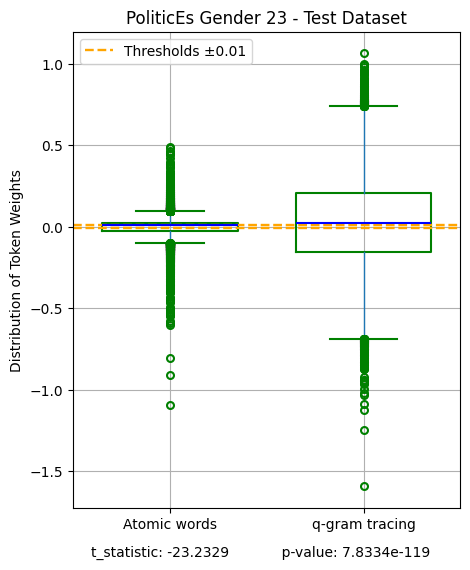

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

line_color = 'green'
line_width = 1.5

df_sin_outliers_z.boxplot(
    ['word_weight', 'q_grams_weight'],
    figsize=(5, 7),
    widths=0.7,
    boxprops=dict(color=line_color, linewidth=line_width),
    #whiskerprops=dict(color=line_color, linewidth=line_width),
    capprops=dict(color=line_color, linewidth=line_width),
    medianprops=dict(color='blue', linewidth=line_width),
    flierprops=dict(marker='o', markerfacecolor='none', markersize=5, markeredgecolor=line_color, markeredgewidth=line_width)

plt.gca().set_xticklabels(['Atomic words', 'q-gram tracing'])

plt.title('PoliticEs Gender 23 - Test Dataset')
plt.gca().set_ylabel("Distribution of Token Weights")

plt.axhline(y=umbral, color='orange', linestyle='--', linewidth=1.7, label=f'Thresholds ±{umbral}')
plt.axhline(y=umbral * -1, color='orange', linestyle='--', linewidth=1.7)
plt.legend()

plt.subplots_adjust(bottom=0.2)
plt.figtext(0.5, 0.13,f"t_statistic: {round(t_statistic,4)}            p-value: {p_value:.4e}", ha="center", fontsize=10, color="black")

f_n = f"/content/drive/MyDrive/Colab Notebooks/fig_politices_gender_23.png"
#plt.savefig(f_n, bbox_inches='tight')

plt.show()

In [ ]:
p_value

3.885662783452732e-105